### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%config InlineBackend.figure_format='retina'
import emcee

### 1. Plot the data with the uncertainties.

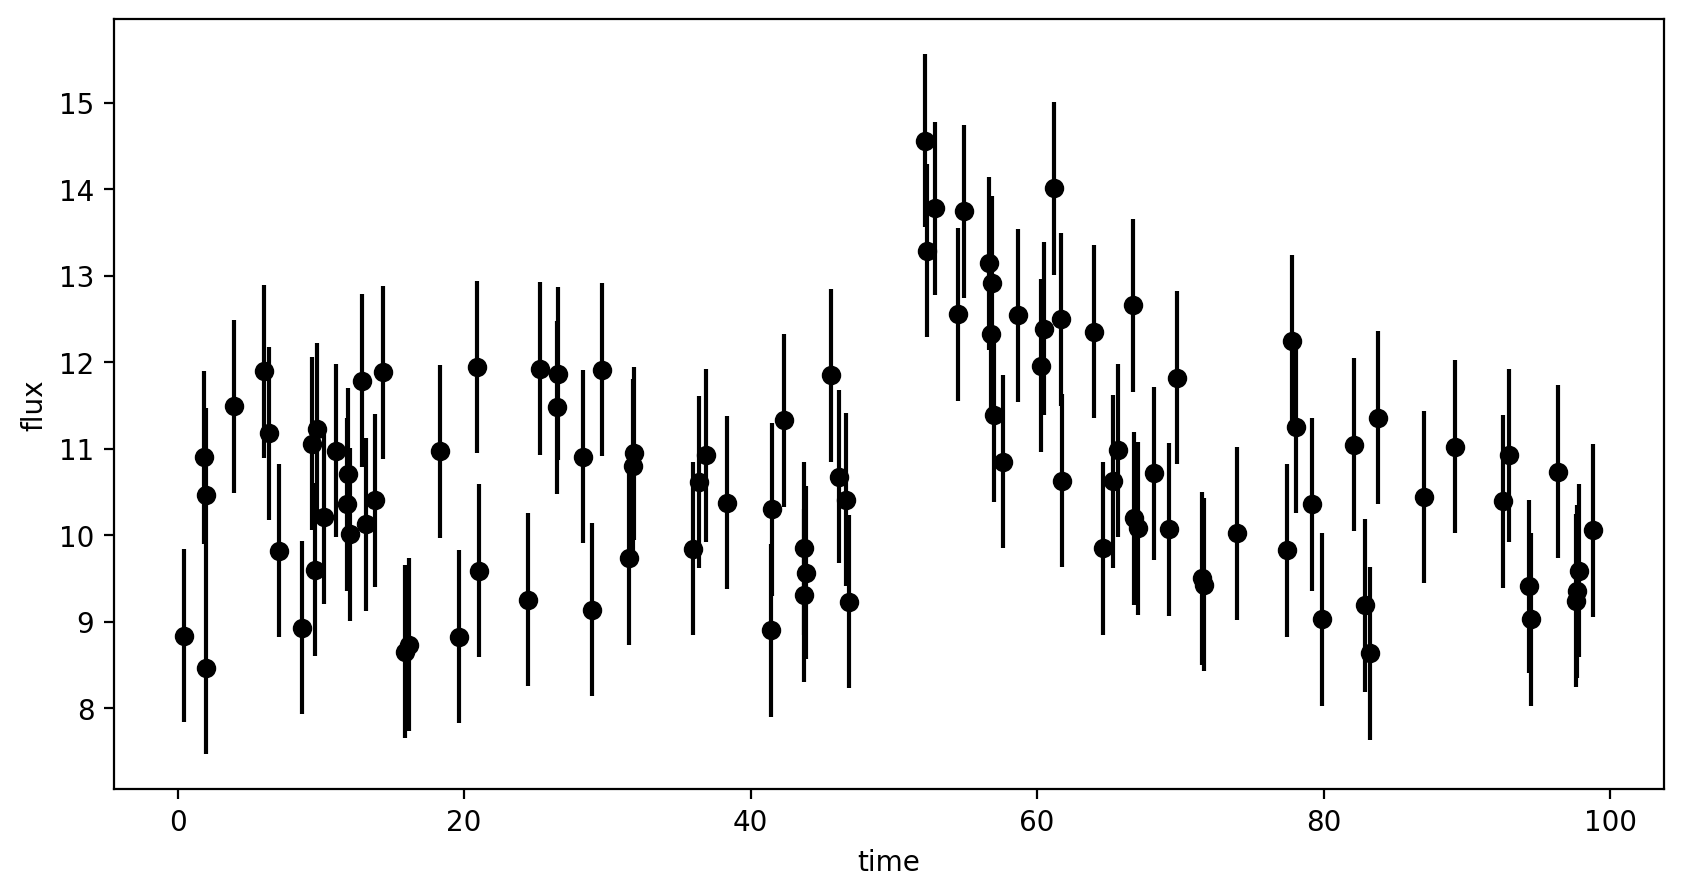

In [173]:
data = np.load('./hw_data/hw5_data_1.npy')
time = data[:,0]
flux = data[:,1]
err = data[:,2]
plt.figure(figsize=(10,5))
plt.errorbar(time,flux, yerr=err, fmt='o',c='black')
plt.xlabel('time')
plt.ylabel('flux')

plt.show()

### 2. Defined burst model and likelihood for the burst model

In [104]:
""" Our free parameters to define the model are: t0,b,A,alpha defined in array "params" """
def burst_model(params):
    """Define a model based on four params: t0,b,A,alpha"""
    t0,b,A,alpha = params
    time = data[:,0]
    flux_modelled = []
    for t in time:
        if t<t0:
            flux_modelled.append(b)
        if t>=t0:
            flux_modelled.append(b + A*np.exp(-alpha*(t-t0)))
            
    return flux_modelled # Return a model shape based on one set of parameter values.
  
def log_likelihood(params):
    """Define a model based on four params: t0,b,A,alpha"""
    t0,b,A,alpha = params
    """ For some params (defined model shape), find the likelihood of the data (flux) assuming Gaussian Likelihood on that flux value"""
    flux = data[:,1]
    flux_modelled = burst_model(params)
    """ Get log likelihood """
    log_likelihood = -0.5 * np.sum(((flux-flux_modelled)**2) / err**2)
    
    return log_likelihood

In [119]:
# Since I am going to use emcee which requires log_posterior, it is better to use log priors and log likelihoods to avoid division by zero

def log_priors(params):
    t0,b,A,alpha = params
    if alpha > 0:
        if 0<t0<100 and 0<b<50 and 0<A<50 and -5<np.log(alpha)<5:
            return 0.0 # we want uniform value for parameter to be 1, so log(param=1) = 0
        else:
            return -np.inf # we want uniform value for paramter to be = 0, so log(0) is -infinity
    else: 
        return -np.inf # we want uniform value for paramter to be = 0, so log(0) is -infinity

def log_posterior(params):
    if not np.isfinite(log_priors(params)): # again we want posterior to be 0 when prior is 0 and thus log(0) = -infinity
        return -np.inf
    else: 
        return log_likelihood(params) + log_priors(params) # Posterior = Likelihood x Priors


In [153]:
# ndim = 4  # number of parameters in the model
# nwalkers = 24  # number of MCMC walkers
# nsteps = 100000  # number of MCMC steps to take **for each walker**

# starting_guesses = np.random.random((nwalkers, ndim))

# # the function call where all the work happens: 
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
# sampler.run_mcmc(starting_guesses, nsteps)

State([[51.42921937 10.15177002  4.05491188  0.13902183]
 [47.14966546 10.49244912  9.11531788  0.16038945]
 [50.96714256 10.02352039  4.32434747  0.07935247]
 [49.07785853 10.57550954  4.67055823  0.12273997]
 [50.04261165 10.43185432  4.80230745  0.10655465]
 [50.39452577 10.41760834  4.64518605  0.13913509]
 [51.56907459 10.31596048  3.90671614  0.14195081]
 [50.81375516 10.29234516  4.19150147  0.10865626]
 [48.28685619 10.53572733  7.91617384  0.16397842]
 [52.08206227 10.24801579  3.74196994  0.11825263]
 [49.39492323 10.20442777  4.04792451  0.09061836]
 [47.42646277 10.23272087  6.67405411  0.10451138]
 [50.86671483 10.44604609  4.30948579  0.15328215]
 [47.71646311 10.33493897  8.30398862  0.14952282]
 [48.78594153 10.39943972  5.64797435  0.13120244]
 [48.65128806 10.16616094  4.73894639  0.08950633]
 [49.02375016 10.34430979  5.79644844  0.11539395]
 [47.0378131  10.14804715  9.95575214  0.14677527]
 [49.09601457 10.4071123   4.609514    0.1084924 ]
 [51.97567429 10.1766973 

(1200000, 4)


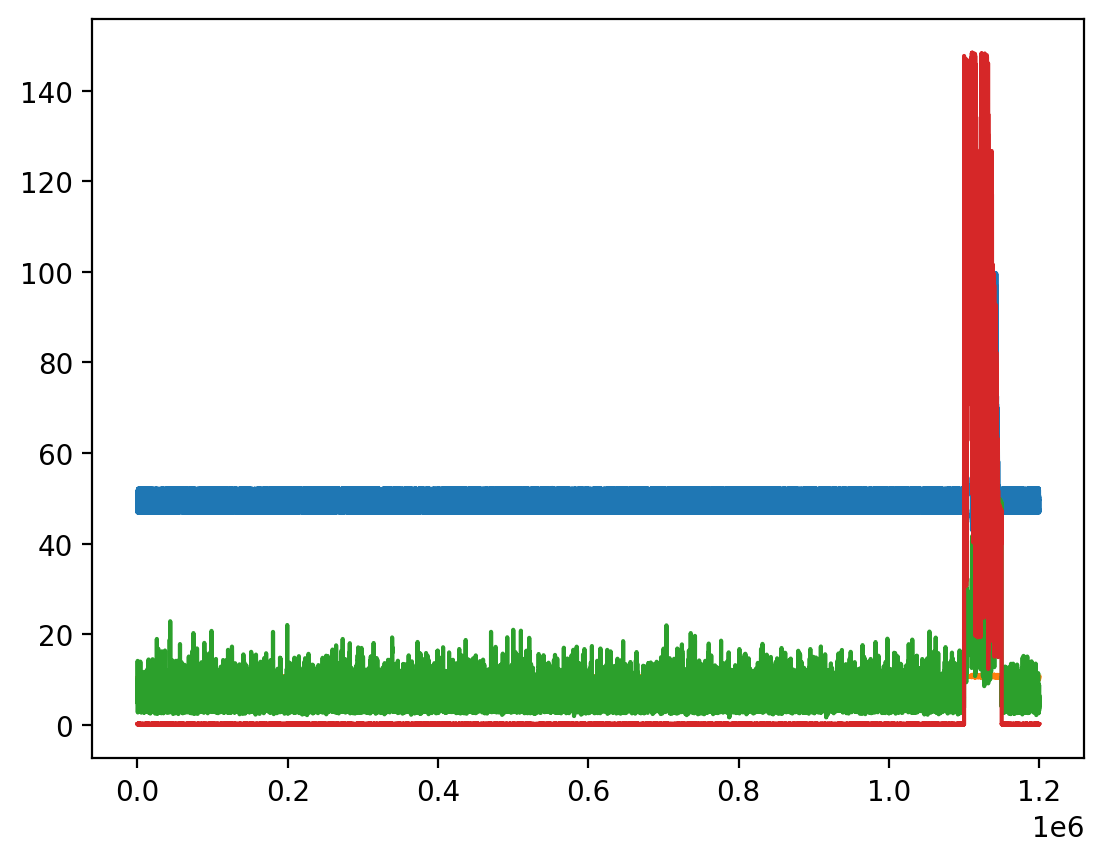

In [174]:
burn = 50000  # "burn-in" period to let chains stabilize
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)  #burned and flattened chain
print(emcee_trace.shape)
plt.plot(emcee_trace)
# we see walker 23 did not converge

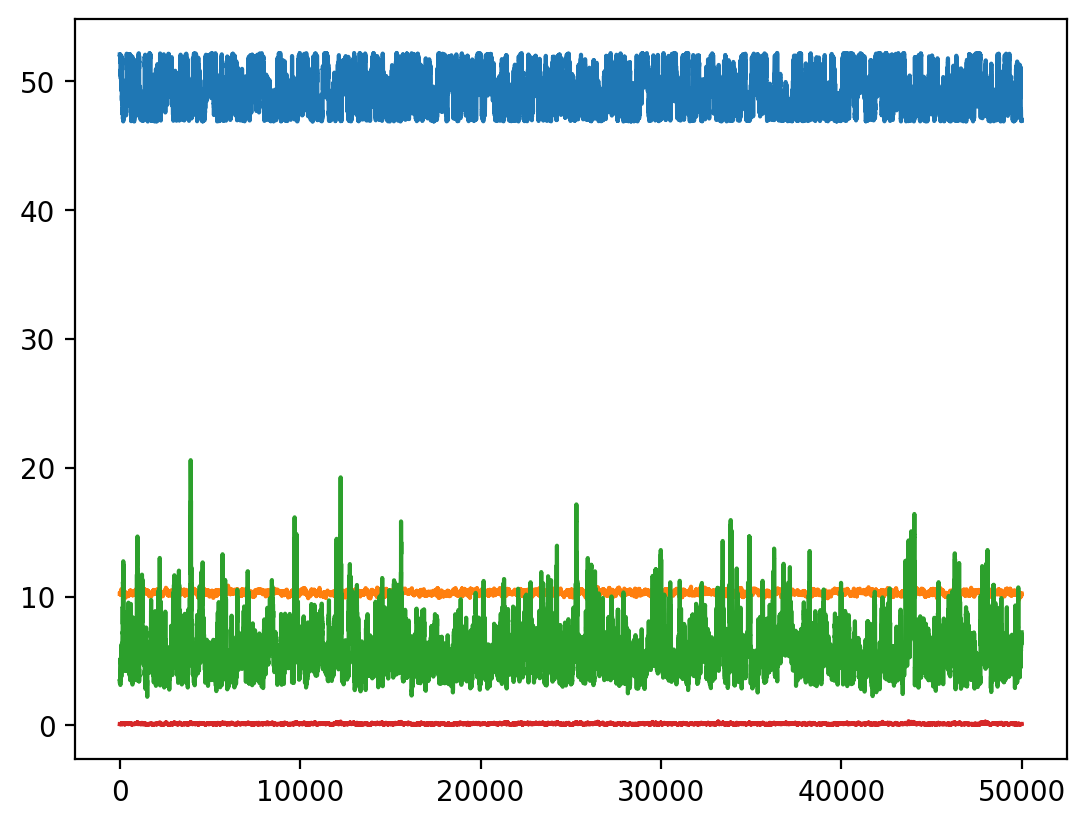

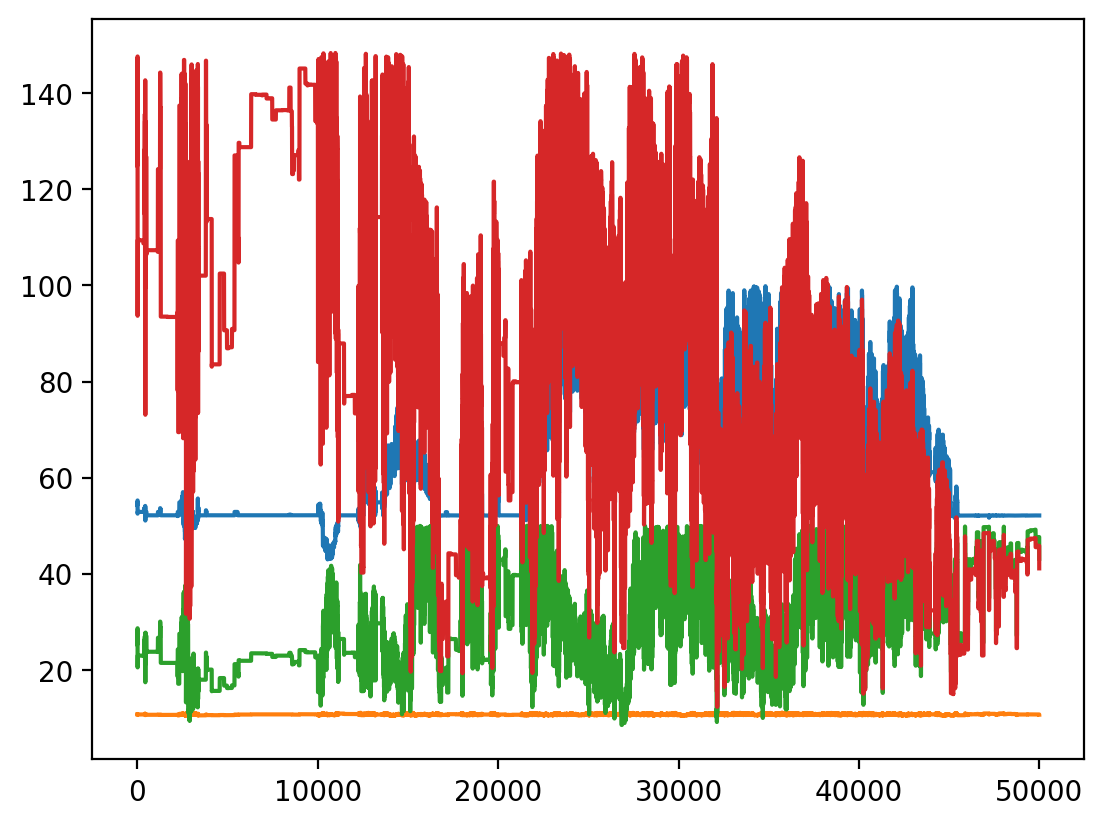

In [176]:
chain = sampler.get_chain()
plt.plot(chain[50000::,21]);
plt.show()
plt.plot(chain[50000::,22]);
plt.show()

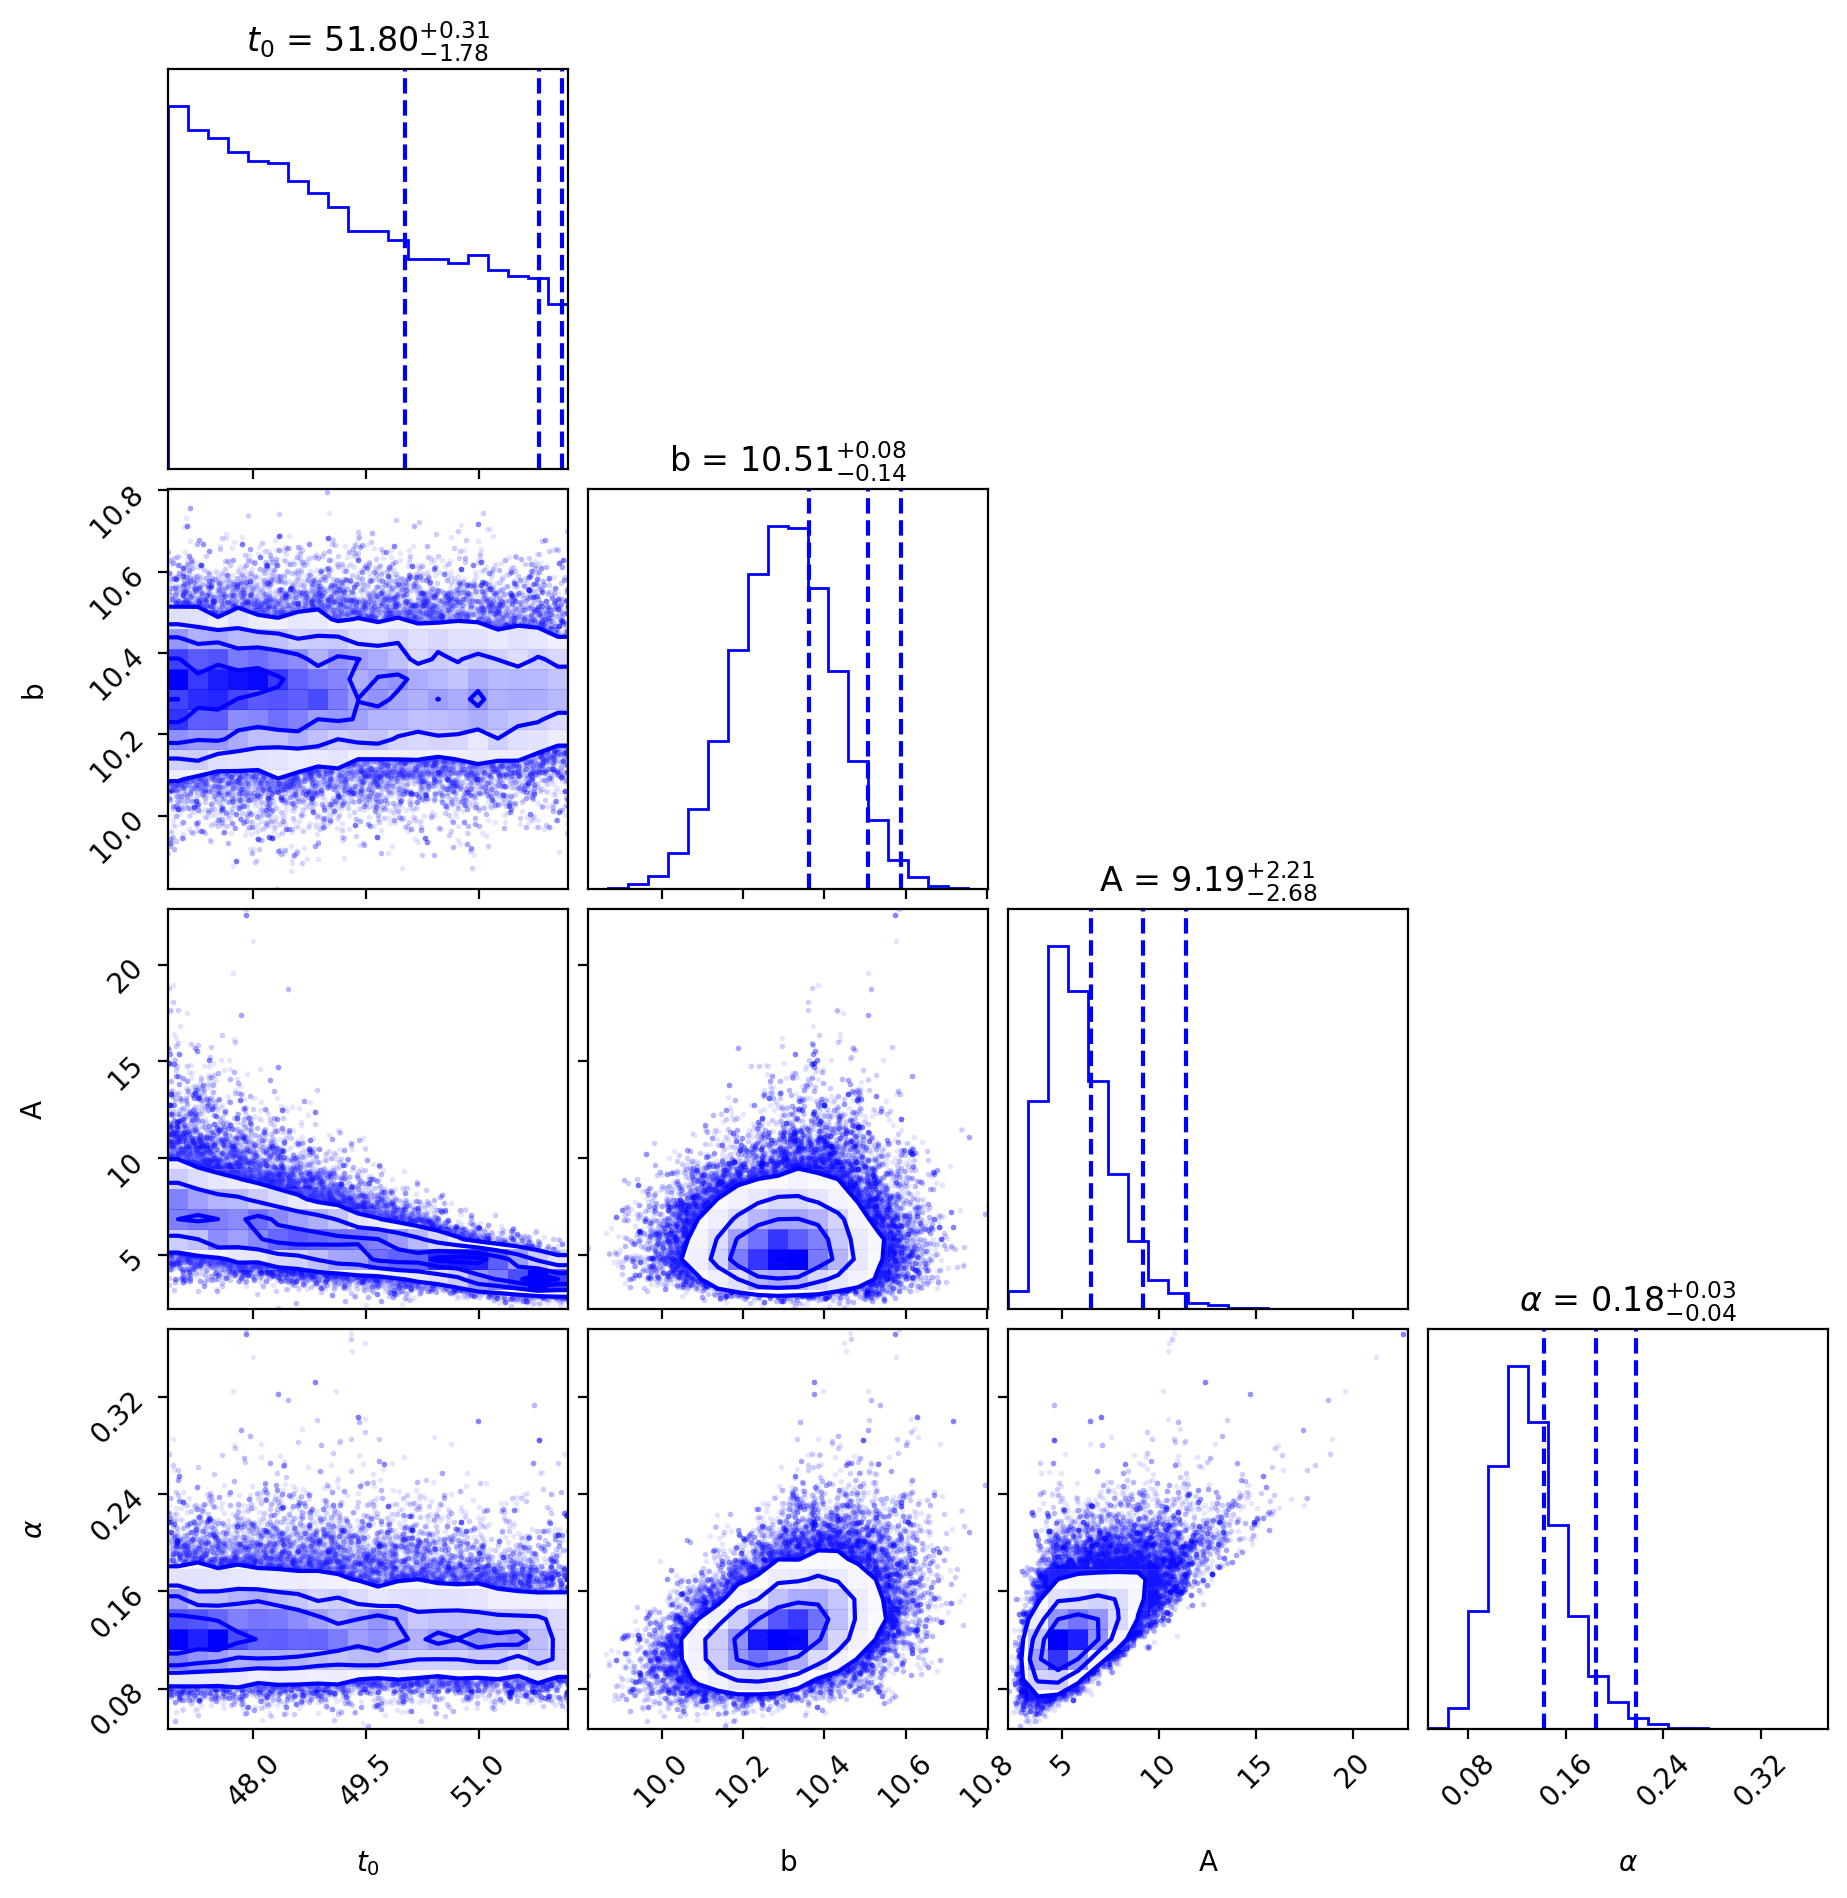

In [177]:
import corner
chain = sampler.get_chain()
corner.corner(chain[10000::,0],labels=[r'$t_{0}$','b','A',r'$\alpha$'],quantiles=[.68,.95,.99],show_titles=True,color='b');

<span style="color:red"> NP: missing #6 & #7? -3 pts each. </span>